In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import SimpleITK as sitk
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [3]:
datafile_path = "/kaggle/input/lung-tumor-ds/dataset_lung.xlsx"
dataset = pd.read_excel(datafile_path)

In [4]:
print("Dataset Preview:")
print(dataset.head())

print("\nDataset Info:")
print(dataset.info())
print("\nMissing Values:")
print(dataset.isnull().sum())
print("\nDuplicated Entries:", dataset.duplicated().sum())

Dataset Preview:
            Full_slice            Nodule  TumorClass
0  pat1_fullslice.nrrd  pat1_nodule.nrrd           5
1  pat2_fullslice.nrrd  pat2_nodule.nrrd           5
2  pat3_fullslice.nrrd  pat3_nodule.nrrd           2
3  pat4_fullslice.nrrd  pat4_nodule.nrrd           5
4  pat5_fullslice.nrrd  pat5_nodule.nrrd           4

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Full_slice  2363 non-null   object
 1   Nodule      2363 non-null   object
 2   TumorClass  2363 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 55.5+ KB
None

Missing Values:
Full_slice    0
Nodule        0
TumorClass    0
dtype: int64

Duplicated Entries: 0



Class Distribution:
TumorClass
3    1092
2     457
4     418
1     244
5     152
Name: count, dtype: int64


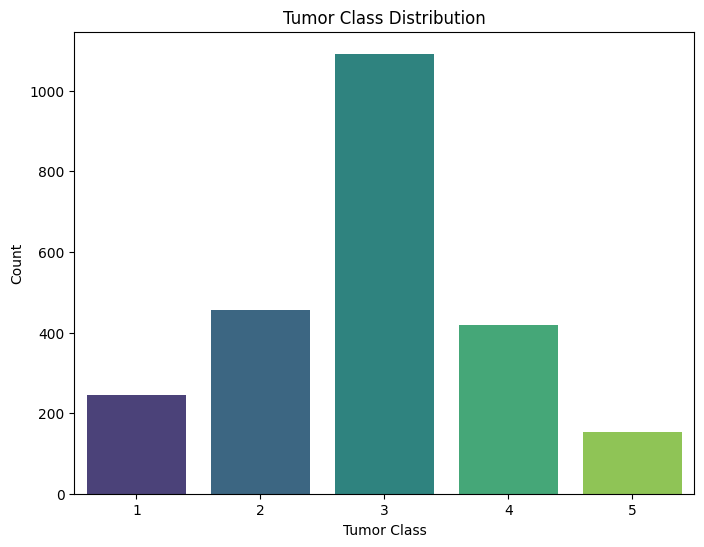

In [5]:
class_counts = dataset['TumorClass'].value_counts()
print("\nClass Distribution:")
print(class_counts)

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Tumor Class Distribution")
plt.xlabel("Tumor Class")
plt.ylabel("Count")
plt.show()

In [6]:
def load_nrrd(file_path):
    try:
        image = sitk.ReadImage(file_path)
        array = sitk.GetArrayFromImage(image)
        return array
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

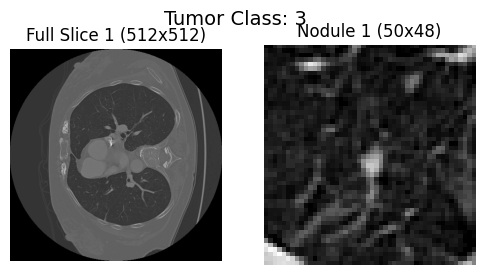

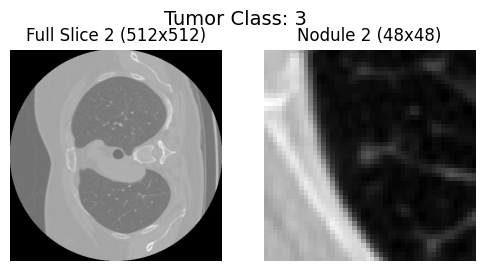

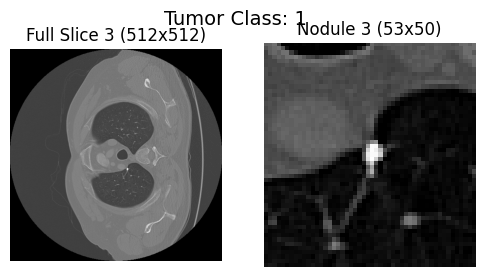

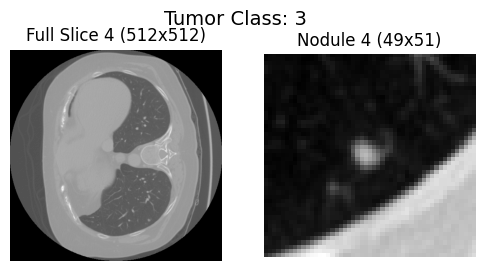

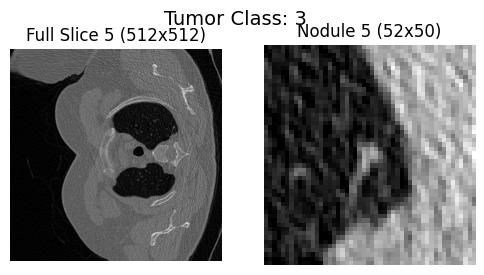

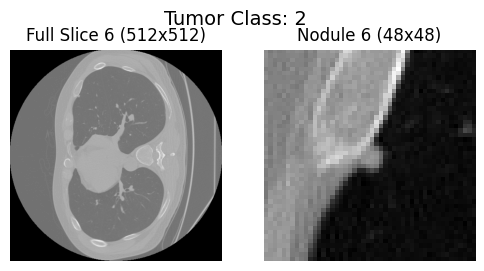

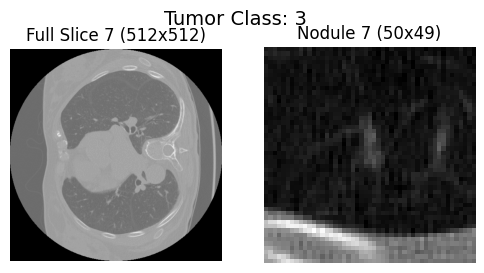

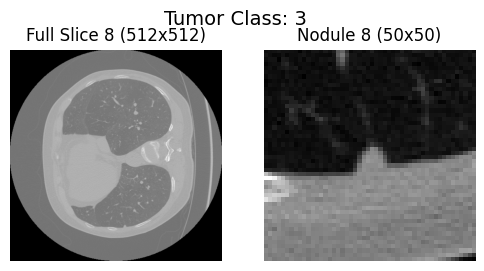

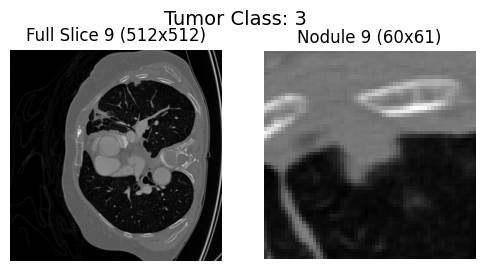

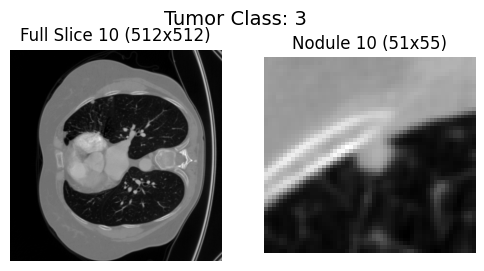

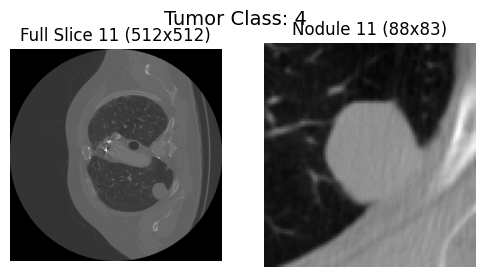

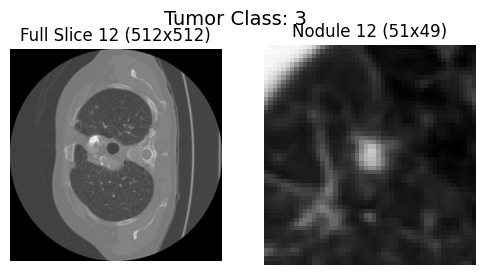

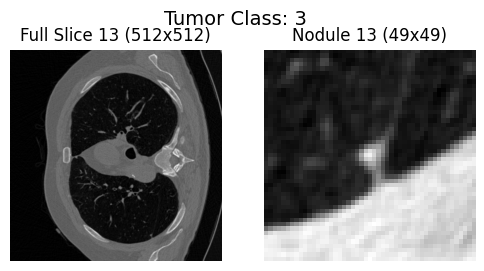

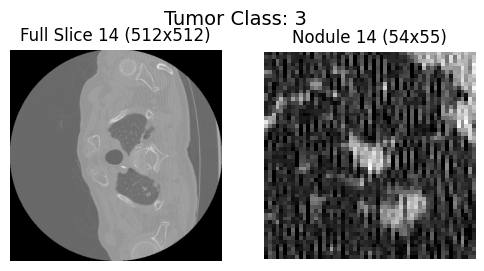

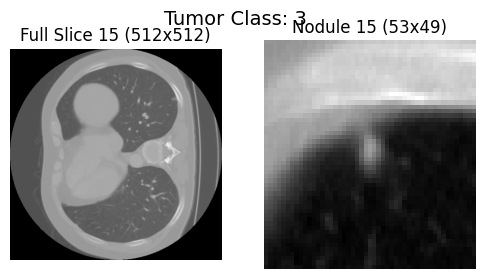

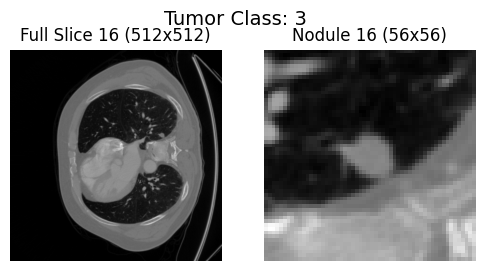

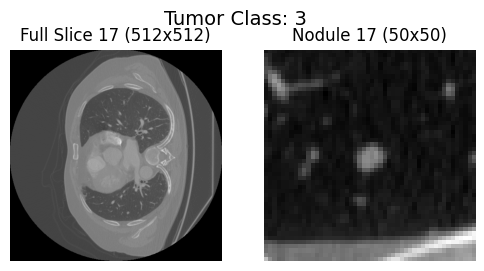

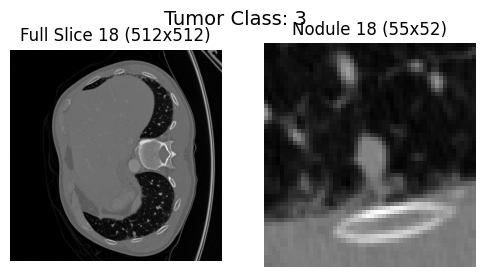

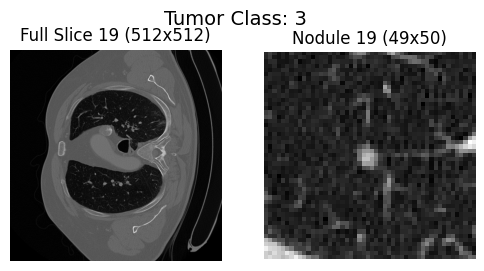

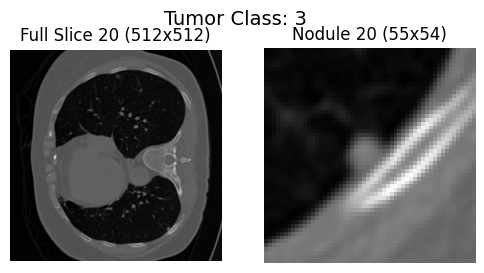

In [27]:
image_dir = "/kaggle/input/lung-tumor-ds/Train"

random_samples = dataset.sample(20)

for i, (_, row) in enumerate(random_samples.iterrows()):
    full_slice_path = os.path.join(image_dir, row['Full_slice'])
    nodule_path = os.path.join(image_dir, row['Nodule'])

    # Load the images
    full_slice = load_nrrd(full_slice_path)
    nodule = load_nrrd(nodule_path)

    # Visualize the images
    if full_slice is not None and nodule is not None:
        plt.figure(figsize=(6, 3))

        # Check dimensions and handle appropriately for full_slice
        full_slice_2d = full_slice[0] if len(full_slice.shape) > 2 else full_slice
        plt.subplot(1, 2, 1)
        plt.imshow(full_slice_2d, cmap="gray")
        plt.title(f"Full Slice {i+1} ({full_slice_2d.shape[0]}x{full_slice_2d.shape[1]})")
        plt.axis("off")

        # Check dimensions and handle appropriately for nodule
        nodule_2d = nodule[0] if len(nodule.shape) > 2 else nodule
        plt.subplot(1, 2, 2)
        plt.imshow(nodule_2d, cmap="gray")
        plt.title(f"Nodule {i+1} ({nodule_2d.shape[0]}x{nodule_2d.shape[1]})")
        plt.axis("off")

        plt.suptitle(f"Tumor Class: {row['TumorClass']}", fontsize=14)
        plt.show()

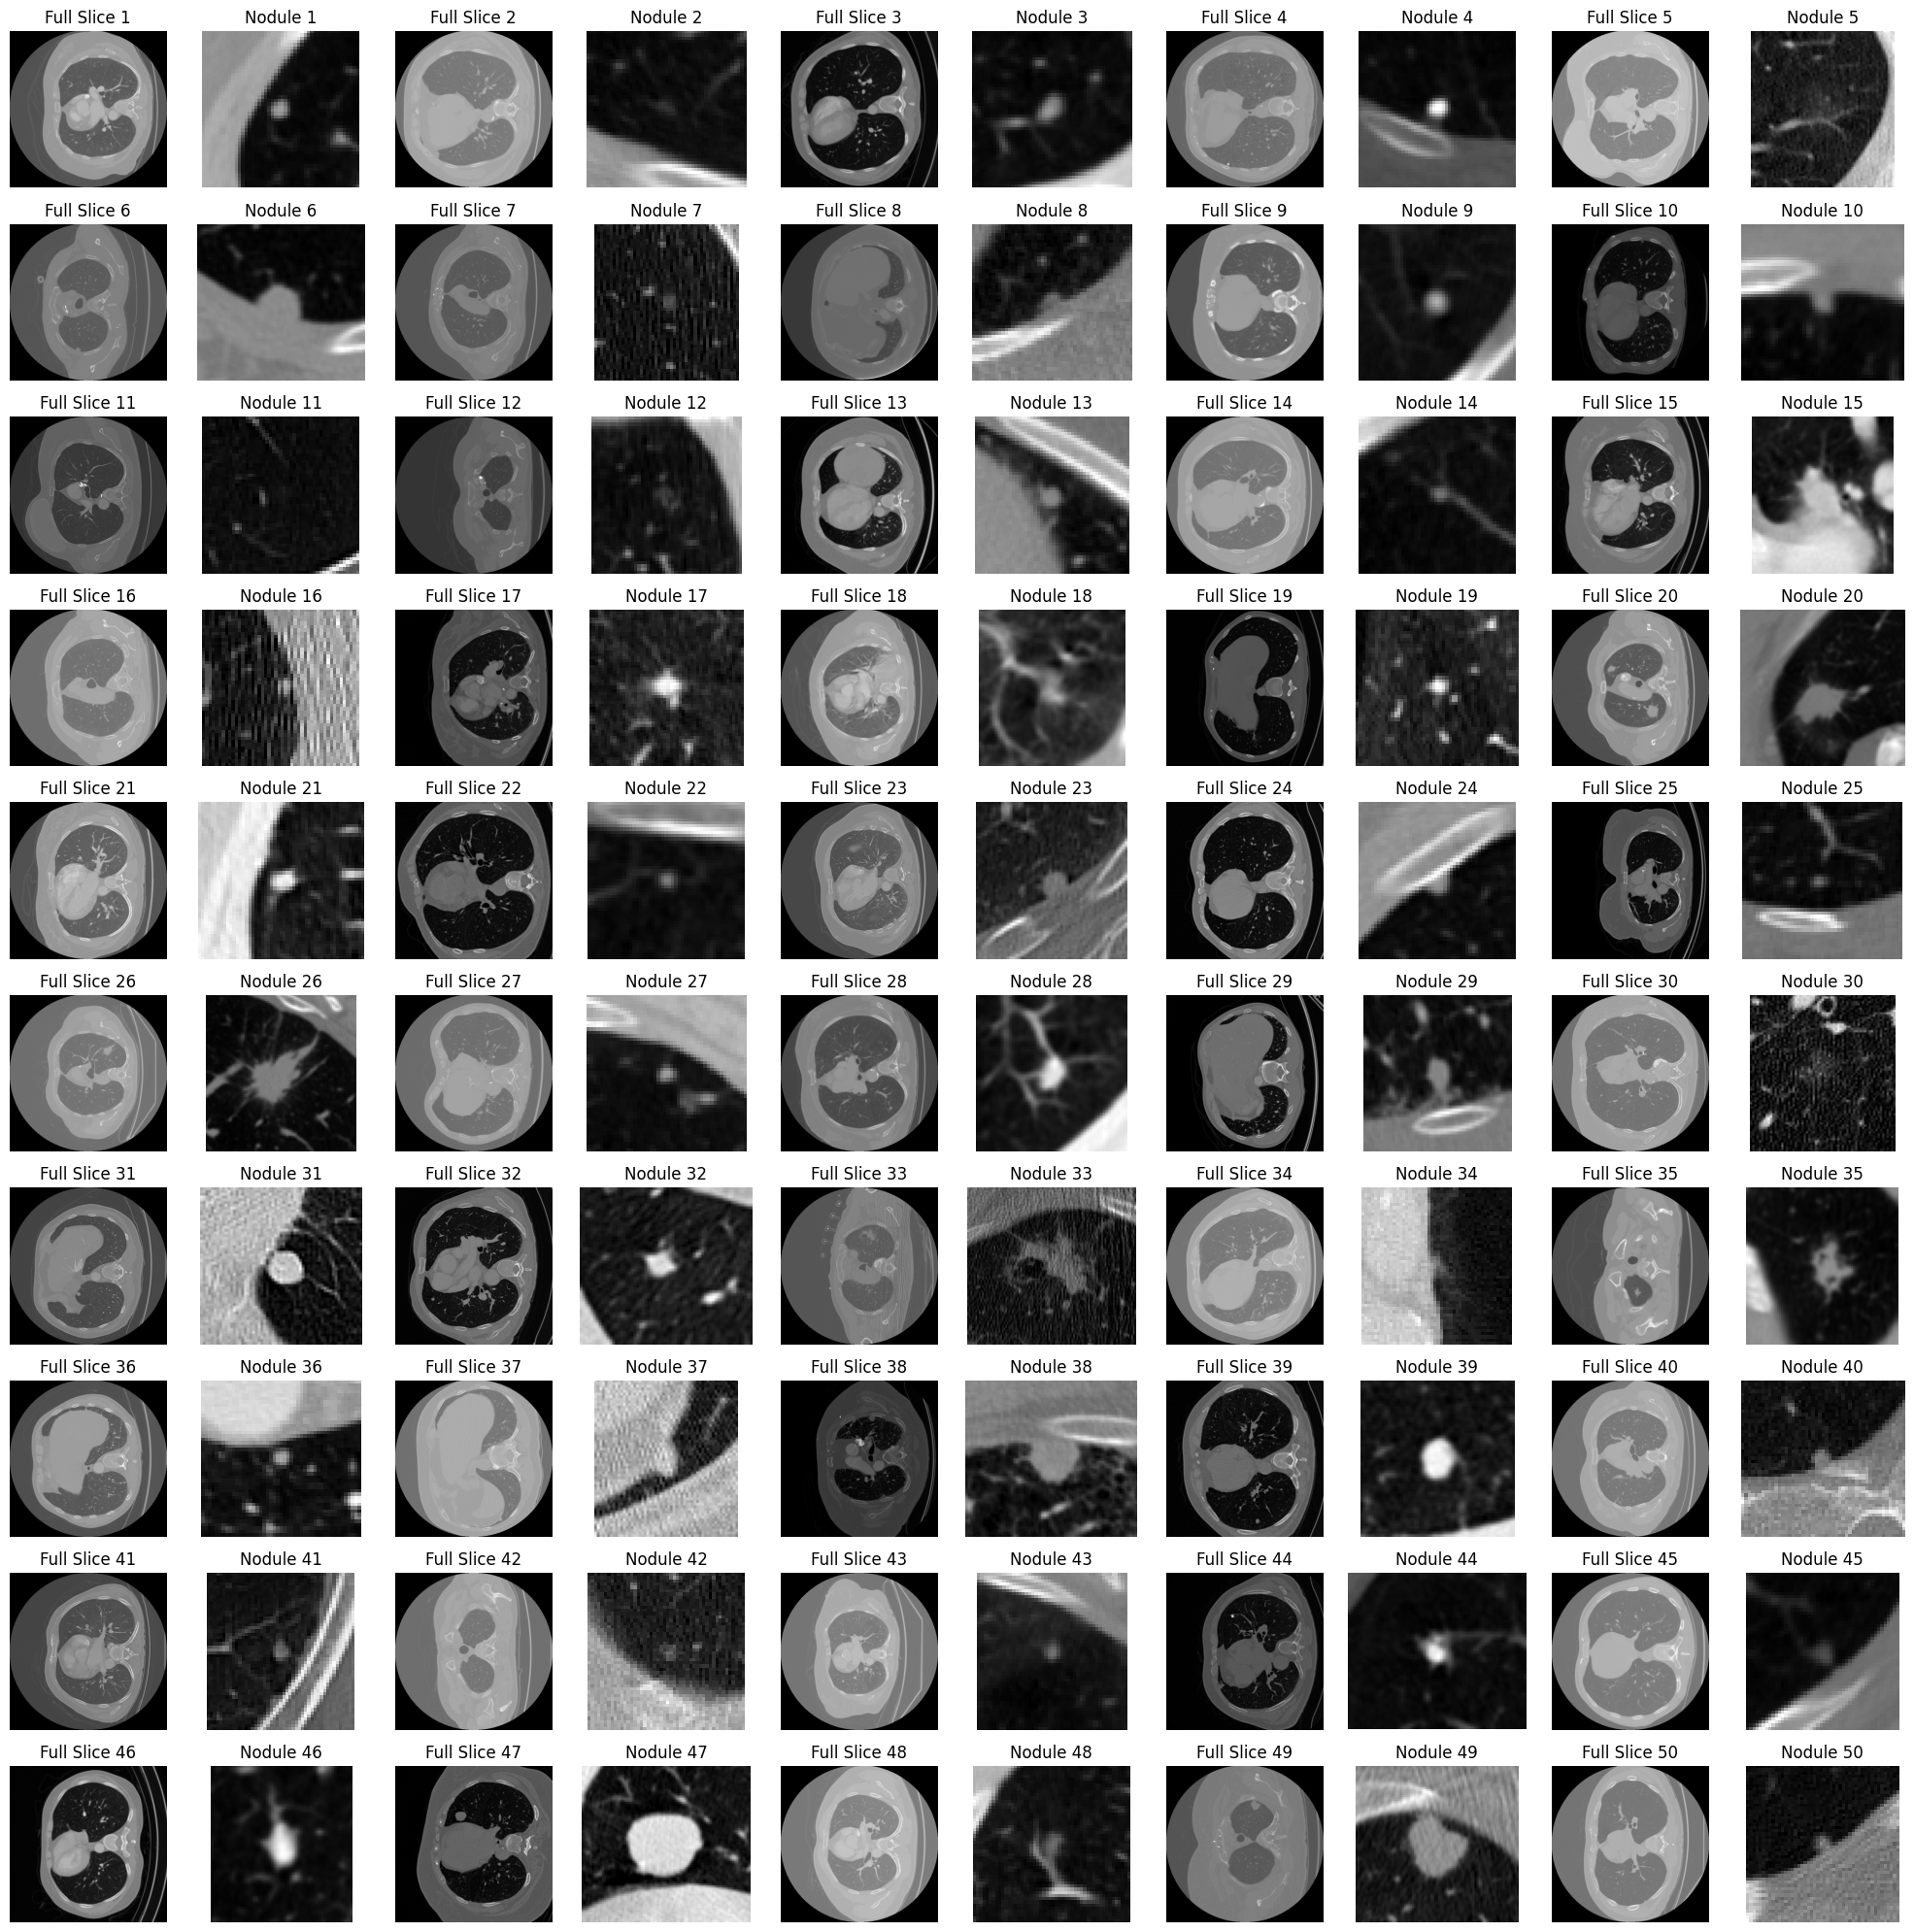

In [32]:
def display_coarse_samples(dataset, image_dir, n_samples=50, n_cols=10):
    # Select n_samples randomly from the dataset
    sampled_data = dataset.sample(n_samples)

    # Adjust the number of rows based on the number of samples and columns
    n_rows = int(np.ceil(n_samples * 2 / n_cols))  # 2 images per sample (Full Slice and Nodule)

    # Create a plot with n_cols columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    # Flatten axes for easy indexing
    axes = axes.flatten()

    idx = 0
    for _, row in sampled_data.iterrows():
        full_slice_path = os.path.join(image_dir, row['Full_slice'])
        nodule_path = os.path.join(image_dir, row['Nodule'])

        # Load images
        full_slice = load_nrrd(full_slice_path)
        nodule = load_nrrd(nodule_path)

        if full_slice is not None and nodule is not None:
            full_slice_2d = full_slice[0] if len(full_slice.shape) > 2 else full_slice
            nodule_2d = nodule[0] if len(nodule.shape) > 2 else nodule

            # Plot Full Slice
            axes[idx].imshow(full_slice_2d, cmap="gray")
            axes[idx].axis("off")
            axes[idx].set_title(f"Full Slice {idx // 2 + 1}")
            idx += 1

            # Plot Nodule
            axes[idx].imshow(nodule_2d, cmap="gray")
            axes[idx].axis("off")
            axes[idx].set_title(f"Nodule {idx // 2 + 1}")
            idx += 1

    # Hide any unused axes
    for i in range(idx, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

display_coarse_samples(dataset, image_dir, n_samples=50, n_cols=10)

In [33]:
print("\nBasic Statistics for Tumor Classes:")
print(dataset['TumorClass'].describe())

full_slice_means = []
nodule_means = []

for _, row in dataset.iterrows():
    full_slice = load_nrrd(os.path.join(image_dir, row['Full_slice']))
    nodule = load_nrrd(os.path.join(image_dir, row['Nodule']))

    if full_slice is not None:
        full_slice_means.append(np.mean(full_slice))
    if nodule is not None:
        nodule_means.append(np.mean(nodule))

print("\nMean Intensities:")
print(f"Full Slice: Mean={np.mean(full_slice_means):.2f}, Std={np.std(full_slice_means):.2f}")
print(f"Nodule: Mean={np.mean(nodule_means):.2f}, Std={np.std(nodule_means):.2f}")


Basic Statistics for Tumor Classes:
count    2363.000000
mean        2.905628
std         1.015951
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: TumorClass, dtype: float64

Mean Intensities:
Full Slice: Mean=-783.50, Std=207.77
Nodule: Mean=-591.19, Std=184.99


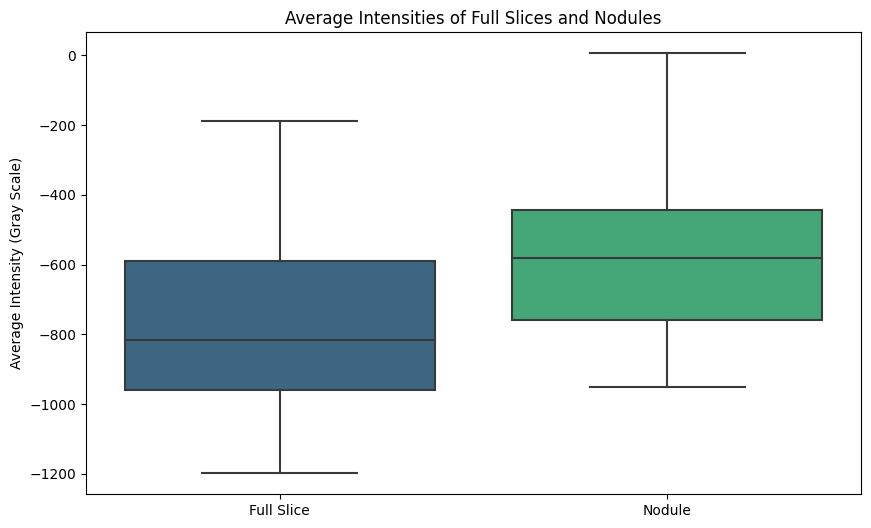


Mean Intensities:
Full Slice: Mean=-783.50, Std=207.77
Nodule: Mean=-591.19, Std=184.99


In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=[full_slice_means, nodule_means], palette="viridis")
plt.xticks([0, 1], ["Full Slice", "Nodule"])
plt.ylabel('Average Intensity (Gray Scale)')
plt.title('Average Intensities of Full Slices and Nodules')
plt.show()

print("\nMean Intensities:")
print(f"Full Slice: Mean={np.mean(full_slice_means):.2f}, Std={np.std(full_slice_means):.2f}")
print(f"Nodule: Mean={np.mean(nodule_means):.2f}, Std={np.std(nodule_means):.2f}")


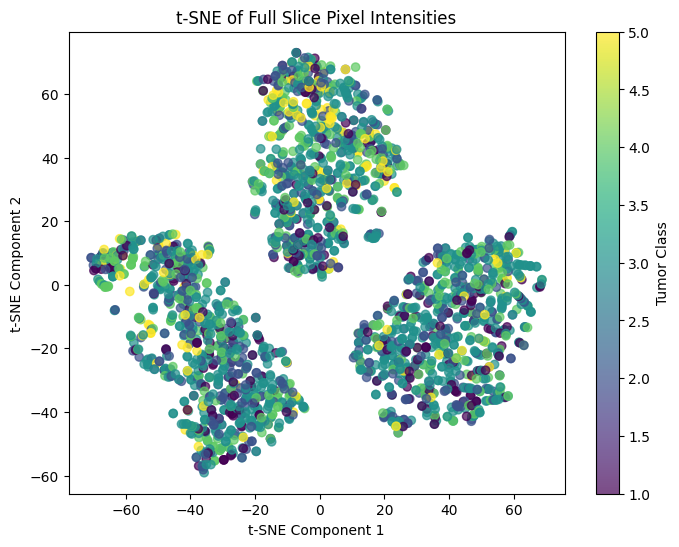

In [35]:
def tsne_analysis(image_paths, label, title):
    image_vectors = []
    for path in image_paths:
        image = load_nrrd(path)
        if image is not None:
            image_2d = image[0] if len(image.shape) > 2 else image
            image_vectors.append(image_2d.flatten())

    image_vectors = np.array(image_vectors)
    if len(image_vectors) > 0:
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(image_vectors)

        plt.figure(figsize=(8, 6))
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=label, cmap="viridis", alpha=0.7)
        plt.colorbar(label="Tumor Class")
        plt.title(title)
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.show()

# Prepare data for t-SNE analysis
image_dir = "/kaggle/input/lung-tumor-ds/Train"

# Full Slice t-SNE
full_slice_paths = [os.path.join(image_dir, row['Full_slice']) for _, row in dataset.iterrows()]
full_slice_labels = dataset['TumorClass'].values
tsne_analysis(full_slice_paths, full_slice_labels, "t-SNE of Full Slice Pixel Intensities")

# Nodule t-SNE
#nodule_paths = [os.path.join(image_dir, row['Nodule']) for _, row in dataset.iterrows()]
#nodule_labels = dataset['TumorClass'].values
#tsne_analysis(nodule_paths, nodule_labels, "t-SNE of Nodule Pixel Intensities")